# An LSTM Neural Net to predict depression, or depression symptoms based on the PHQ-8 from transcribed verbal data 

### Specifically, data are utterances which includes the words uttered (learned as embeddings) and linguistic features utterance from LIWC.

* this code is exploratory, may contain errors!
* python 2 with Tensorflow
* prediction options include: depression level (continuous, low/med/high, or binary), level for each depression symptom based on PHQ-8 (low/med/high, or binary). Need to change the cost function in the code depending on the outcome chosen. 
* data is unbalanced, so options in code for 1) undersampling the majority class (lower levels of depression) and 2) cost-senstive learning
* various options for drop out, L1/L2 regaularization

Unique features of this model compared to other frameworks explored:
* includes embedding layer prior to LSTM layer. Here, The emebddings are learned along the way not pre-trained. 
* concatenates the utterances (turned into word-embeddings) with and linguistics features of the utterances (from LIWC)
* includes dense (fully connected) output layer
* sequences of various lengths may be used. In this code, there is no option yet written for a sliding window of words (see the other LSTM code in this repo for examples).
* debug_sentences allows us to write the sentences in each part of the confusion matrix to a file for later examination of the erors


Alina notes to self:
* data corresponding to IDs without meta-information and data corresponding to missing target information are excluded in Load_Data()
* for variable coding see codebook excel

Helpful tutorials:
* https://github.com/nfmcclure/tensorflow_cookbook/blob/master/09_Recurrent_Neural_Networks/02_Implementing_RNN_for_Spam_Prediction/02_implementing_rnn.py
* Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf; Author: Aymeric Damien; Project: https://github.com/aymericdamien/TensorFlow-Examples/    

In [134]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import sys
import csv

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from decimal import *

cwd= os.getcwd()

In [135]:
# ==========
#   MODEL
# Some LSTM code and code structure reused from M. Morales

# ==========
class BaseConfiguration:

    def __init__(self):
        self.learning_rate = 0.0001 #also try .001, i think accuracy and confusion matrix could be more stable with lower learning rate
        self.training_iters = 30000000  #was 50,000,000. Consider reducing further if you notice that the testing accuracy becomes stable (or starts dropping) earlier than this number of iterations, to prevent overfitting. 
        self.batch_size = 50
        self.display_step = 1
        self.val_step = 50
        self.L2_penalty= 0.0 #beta term on L2 weight penalty for L2 normalization, if set to 0.0 for no L2 normalization. I think confusion matrix becomes unbalanced (but accuracy higher) with L2 noamlization
        # Network Parameters
        self.seq_max_len = 30 # Sequence max length. 
        self.seq_min_len = 7
        self.embedding_size = 20 #so far best was 10 emebdding, 15 hidden
        self.n_hidden = 15 # hidden layer num of features, per layer
        self.n_classes = 1 # linear sequence or not, this code is meant for linear sequence only!
        self.num_layers = 1 #to add more layers: https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html
        self.keep_prob = .9 #for no dropout, use 1. This only performs dropout on the LSTM layer, for outputs. If config.n_layers>1, dropout will work on every layer, i.e., if set dropout to .9 and 2 layers, total dropout is ,.9*.9
        self.debug_sentences = True #if True, sentences corresponding to each cell in the confusion matrix are written in folder "sentence_validation"
        self.min_word_frequency=15 #wont work well below 15
        self.validation_IDs_proportion=.1 #proportion of IDs (among IDs that exist in meta data, and have the specified target value) that are held out as "validation" data
        self.balance_classes=True #use for balancing classification with undersampling. If True, will only sample the number of the minority category utterances to be same as high utterances (for training data)
        self.linguistic_feats= 56 #this is what is in utterance with LIWC features file as is, includes 55 ling feats and 1 feat for #words
    def printConfiguration(self):
        # print configuration
        print ('---------- Configuration: ----------')
        print ('learning_rate', self.learning_rate)
        print ('training_iters', self.training_iters)
        print ('batch_size', self.batch_size) 
        print ('L2_penalty', self.L2_penalty) 

        # Network Parameters
        print ('seq_max_len', self.seq_max_len )# Sequence max length
        print ('seq_min_len', self.seq_min_len)
        print ('embedding_size', self.embedding_size)
        print ('n_hidden', self.n_hidden) # hidden layer num of features
        print ('n_classes', self.n_classes) # linear sequence or not
        print ('num_layers', self.num_layers)
        print ('keep_prob (dropout = 1-keep_prob)', self.keep_prob)
        print ('------------------------------------')
	#print 'n_hidden: ', self.n_hidden, 'learning rate: ', self.learning_rate, ' batch_size: ', self.batch_size, ' max_len: ', self.seq_max_len, ' min_len: ', self.seq_min_len

# Parameters
# configuration
config = BaseConfiguration()

Reset the tensorflow graph

In [136]:
tf.reset_default_graph() #to reset tensorflow graph if you've already made one graph, once re-set need to run through to get variable agani. 

Set up Tensorflow Graph Input

In [137]:
# tf Graph input
#x = tf.placeholder(tf.float32, [None, config.seq_max_len]) #this placeholder for x used if pre-trained embeddings are used
y = tf.placeholder(tf.float32, [None, config.n_classes]) 

x = tf.placeholder(tf.int32, [None, config.seq_max_len]) #this placeholder for x used if training embedding layer
keep_prob = tf.placeholder(tf.float32)

# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])
ling_features= tf.placeholder(tf.float32, [None, config.linguistic_feats])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([config.n_hidden+config.linguistic_feats, config.n_classes])) #note weights are initialized as normal random variable
}


biases = {
    'out': tf.Variable(tf.random_normal([config.n_classes]))  #note biases are initialized as normal random variable
}

#need to add another set of weights and biases

In [138]:
def random_batch(x, y, sequence_length, LIWC, part_size=0, sentences=None):
    batch_x = []
    batch_y = []
    batch_sequence_length = []
    batch_sentences = []
    batch_LIWC=[]
    indexes = range(len(x))
    random.shuffle(indexes)
    #print(indexes[0:batch_size-1])
    for index in indexes[0:part_size-1]:
        batch_x.append(x[index])
        batch_y.append(y[index])
        batch_sequence_length.append(sequence_length[index])
        batch_LIWC.append(LIWC[index])
        if sentences is not None:
            batch_sentences.append(sentences[index])
    return batch_x, batch_y, batch_sequence_length, batch_LIWC, batch_sentences

def last_relevant(output, length):
    config.batch_size = tf.shape(output)[0]
    max_length = int(output.get_shape()[1])
    output_size = int(output.get_shape()[2])
    index = tf.range(0, config.batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, output_size])
    relevant = tf.gather(flat, index)
    return relevant

In [139]:
def import_meta_data(path):
    """Imports labels as a dictionary- must designate below which label you want"""
    labels = {}
    # load the CSV file as a numpy matrix
    with open (path,'r') as csv:
        dataset = csv.readlines()
    for row in dataset[1:]:
        ID, depression, dep_binary2, depression_value, depression_level_official, Morethan7PHQsympt_Available,PHQ_9NoInterest,PHQ_9Depressed,PHQ_9Sleep,PHQ_9Tired,PHQ_9Appetite,PHQ_9Failure,PHQ_9Concentrating,PHQ_9Moving,PHQ_9NoInterest_level,PHQ_9Depressed_level,PHQ_9Sleep_level,PHQ_9Tired_level,PHQ_9Appetite_level,PHQ_9Failure_level,PHQ_9Concentrating_level,PHQ_9Moving_level  = row.strip().split(',')
        #map depression strings to int values
        try:
            depression_value= int(depression_value.strip())/32 #rescale to be between 0 and 1, max value on PHQ is 8*4=32
        except:
            depression_value ='NA'
        depression_level_official = depression_level_official.strip()
        PHQ_9NoInterest_level = PHQ_9NoInterest_level.strip()
        PHQ_9Depressed_level = PHQ_9Depressed_level.strip()
        PHQ_9Sleep_level = PHQ_9Sleep_level.strip()
        PHQ_9Tired_level = PHQ_9Tired_level.strip()
        PHQ_9Appetite_level = PHQ_9Appetite_level.strip()
        PHQ_9Failure_level = PHQ_9Failure_level.strip()
        PHQ_9Concentrating_level = PHQ_9Concentrating_level.strip()
        PHQ_9Moving_level = PHQ_9Moving_level.strip()  
        
        labels[ID.strip()] = [depression, dep_binary2, depression_value, depression_level_official,PHQ_9NoInterest_level,PHQ_9Depressed_level,PHQ_9Sleep_level,PHQ_9Tired_level,PHQ_9Appetite_level,PHQ_9Failure_level,PHQ_9Concentrating_level,PHQ_9Moving_level]
    return labels
        

#for testing:
#meta_data = import_meta_data('Meta_Data_with_Symptoms.csv')
#meta_data['668'] #311 should have dep score, 668 should have NAs

#for testing:
f = open(cwd+ '/LIWC/re_cleaned_utterances_withLIWC.txt','r')
#lines =  [line.strip().split(',') for line in f.readlines()]
#lines2 =  [line.split(',') for line in f.readlines()]
lines =  [line.strip().split(',') for line in f.readlines()]
for line in lines:
    del line[-1] #because comma at end of last element on a line, need to delete this lingering, empty element
f.close()


liwc_nums= map(float, lines[10][4:len(lines[10])])
liwc_nums= map(Decimal, liwc_nums[4:len(liwc_nums)])     
len(liwc_nums)

relevant= []

for in lines:
    if liwc_nums:
        relevant.append(1) #relevant
    else liwc_nums:
        relevant.append(0) #not relevant

In [140]:
missing_meta=[] #this is just for inspecting IDs that aren't in the meta-data file, and so not used in RNN code
IDs_NAs_inMeta=[] #this is just for inspecting IDs that are in the meta-data file but don't have target values, so not used in RNN code

def load_data(target=None, data_file_path= cwd+ '/LIWC/re_cleaned_utterances_withLIWC.txt', meta_file_path='Meta_Data_with_Symptoms.csv'):

    if target is None:
        print("Target not specified: possible target classes: depression_binary=0, dep_binary2=1, depression_value=2, depression_level_official=3, PHQ_9NoInterest_level=4,PHQ_9Depressed_level=5,PHQ_9Sleep_level=6,PHQ_9Tired_level=7,PHQ_9Appetite_level=8,PHQ_9Failure_level=9,PHQ_9Concentrating_level=10,PHQ_9Moving_level=11")
        raise
    #get labels
    meta_data = import_meta_data(meta_file_path)
    
    #load utterances data
    f = open(data_file_path,'r')
    lines =  [line.strip().split(',') for line in f.readlines()]
    for line in lines:
        del line[-1] #because comma at end of last element on a line, need to delete this lingerin and empty element
    f.close()


    #training data variables
    utterances_withIDs = [] #utterances of training data with meta data (ID of speaker, line in transcript, and quarter of transcript)
    data_y = [] #this will be an array with an element for each sentence in the training data, with the depression label, in the format [X,X,X] 
    sequence_length = [] #vector of sequence lengths for each utterances in the training data
    sentences = [] #just the utterances of training data, no meta data included 
    IDs = [] #training IDs
    LIWC= [] 
    #validation data variables
    utterances_validation=[]  #utterances of validation data with meta data (ID of speaker, line in transcript, and quarter of transcript)
    validation_y =[]  #this will be an array with an element for each sentence in the validation data, with the depression label, in the format [X,X,X] 
    sequence_length_validation=[] #vector of sequence lengths for each utterances in the training data
    sentences_validation=[] #just the utterances of validation data, no meta data included 
    IDs_validation=[] #list of validation IDs so that validation ID's are excluded from training data, and it is in same order as the utterances, sentences, sequence length, y, etc. 
    LIWC_validation =[]
    
    #get validation IDs, and list them in validation_IDs_set
    IDs_noNAs_inMeta=[] #list of IDs in sentences that have corresponding meta data and have the specified target value
    for L in lines:
        ID = L[1].strip() 
        try:
            meta = meta_data[ID]
            if meta[target] != 'NA':
                IDs_noNAs_inMeta.append(ID)
            else:
                IDs_NAs_inMeta.append(ID) #just in case want to track who was excluded
        except:
            missing_meta.append(ID)
            continue       
    validation_IDs_set= random.sample(set(IDs_noNAs_inMeta), int(round(config.validation_IDs_proportion*len(set(IDs_noNAs_inMeta))))) #get number of IDs for validation set based on the proportion set in the configuration, round the number to nearest integer
    
    for L in lines:
        ID = L[1].strip()    
        length = len(L[0].split(" ")) #each line is for example: ['me there at all can you do it at home', ' 602', '1', 'first quarter'], so the 0th item is the words, this is measuring characters, if want to measure words split here split.("\\s+")
        if length > config.seq_max_len: #truncate at max sequence length
            length=config.seq_max_len
        minimum_seqs= config.seq_min_len-1 #such that the minimum length in the next line is inclusive of the minimum number itself (e.g. if minimum sequence length is 6 words then sequences of 6 will be included)
        
        if length > minimum_seqs: #and L[3]!='first_quarter' #use this last piece if want to exclude section of each persons transcript (sections: last_quarter, first_quarter, middle_half)
            try:
                meta = meta_data[ID]
                if meta[target] != 'NA': #exclude participants without data for the specific target
                    if ID not in validation_IDs_set: #IDs in validation set are EXCLUDED from variables below
                        sentences.append(L[0]) 
                        utterances_withIDs.append(L) # can sample among these,below #this is a list of [utterance, id] for each utterance. but only includes those corresponding to indivduals with valid ids
                        IDs.append(ID)
                        sequence_length.append(length)
                        data_y.append([meta[target]])
                        liwc_nums= map(float, L[4:len(L)])
                        liwc_nums= map(Decimal, liwc_nums[4:len(liwc_nums)])     
                        LIWC.append(liwc_nums)
                    else:
                        sentences_validation.append(L[0]) 
                        utterances_validation.append(L) 
                        IDs_validation.append(ID)
                        sequence_length_validation.append(length)
                        validation_y.append([meta[target]])
                        liwc_nums= map(float, L[4:len(L)])
                        liwc_nums= map(Decimal, liwc_nums[4:len(liwc_nums)])     
                        LIWC_validation.append(liwc_nums)        
            except:
                #print('invalid ID: ', ID)
                continue
   
    #change each sentence to a sequence of numbers (each number maps to a word), and if the sequence is less than the max_len, pads on the back of this seuqence withs 0s to reach the max sequence length. 
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(config.seq_max_len,min_frequency=config.min_word_frequency)
    data_x = np.array(list(vocab_processor.fit_transform(sentences))) #words that don't occur frequently enough are replaced with 0 in data_x. Usually, this (could) be an issue since padding uses 0s as well, but in this code it shouldn't be an issue since we explicitly feed the sequence length (see: https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html). If still concerned, instead, could use another symbol like NA or could remove these words entirely?

    #process validation sentences data in way corersponding to dictionary used to process training sentence data
    validation_x= np.array(list(vocab_processor.fit_transform(sentences_validation))) #words that don't occur frequently enough are replaced with 0 in data_x. Usually, this (could) be an issue since padding uses 0s as well, but in this code it shouldn't be an issue since we explicitly feed the sequence length (see: https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html). If still concerned, instead, could use another symbol like NA or could remove these words entirely?

    ##Get vocab size, needed to specify embedding dimensions in the RNN
    vocab_dict = vocab_processor.vocabulary_._mapping
    vocab_size= len(vocab_dict)
    
    #need to reshape utterances_validation, from a list of lists, to a list of strings. each string has 'utterance, ID, line number in transcript, quarter of transcript'
    reshaped_utterances_validation=[]  
    for i in range(0,len(utterances_validation)):
        flatter= ", ".join(utterances_validation[i])
        reshaped_utterances_validation.append(flatter)
    
    return data_x, data_y, sequence_length, IDs, vocab_size, sentences, LIWC, validation_x, validation_y, sequence_length_validation, IDs_validation,sentences_validation, reshaped_utterances_validation, LIWC_validation

In [141]:
dcaps_data, dcaps_label, dcaps_sequence_lengths, dcaps_IDs, vocab_size, dcaps_sentences, LIWC_feats,validation_x, validation_y, sequence_length_validation, IDs_validation,sentences_validation, utterances_validation, LIWC_feats_validation = load_data(target=2) #this needs to be before creating RNN object, since the vocab size is needed to specify the dimensions of the embedding in the RNN 

In [142]:
check_numbers= (dcaps_data, dcaps_label, dcaps_sequence_lengths, dcaps_IDs, dcaps_sentences, validation_x, validation_y, sentences_validation, utterances_validation, sequence_length_validation)
for i in check_numbers:
    print(len(i))

46209
46209
46209
46209
46209
5405
5405
5405
5405
5405


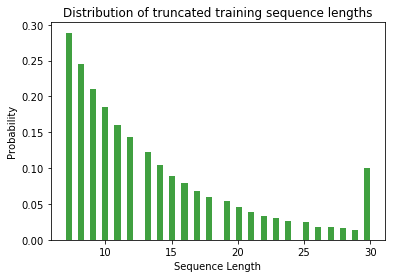

In [143]:
#plot out training data sequence lengths
plt.hist(dcaps_sequence_lengths, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Sequence Length')
plt.ylabel('Probability')
plt.title('Distribution of truncated training sequence lengths')
plt.show()

In [144]:
def write_debug_sentences(valBatch_y, iteration, val_predictions):
    os.makedirs('sentence_validation' + str(iteration))
    with open('sentence_validation' + str(iteration) + '/pred_sents.log', 'w') as f11:
        for i in range(0,len(val_predictions)):
            f11.write(valBatch_sentences[i]+ ',' + str(val_predictions[i]) + '\n') 
            
    f11.close()

In [145]:
def dynamicRNN(x, seqlen, weights, ling_features, biases, vocab_size, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    #print(x.get_shape())
    #x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    # print(x.get_shape())
    # x = tf.reshape(x, [-1, 300])
    # print(x.get_shape())
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    # x = tf.split(0, seq_max_len, x)
    # print(len(x), x[0].get_shape())
    #x = tf.squeeze(x)
    #print(x.get_shape())
    
    
    #need to input dat in: batch_size, n_steps
    with tf.device("/cpu:0"): #http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
        embedding_mat = tf.Variable(tf.random_uniform([vocab_size, config.embedding_size], -1.0, 1.0)) #this should be a matrix vocab size by embedding size
        embedding_output = tf.nn.embedding_lookup(embedding_mat, x)
    #The result of the embedding operation is a 3-dimensional tensor of shape [None, sequence_length, embedding_size].
   
    
    # Define a lstm cell with tensorflow
    if config.num_layers == 1:
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(config.n_hidden)
        if config.keep_prob < 1:
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob) #might also add input_keep_prob
        #init_state = lstm_cell.zero_state(config.batch_size, tf.float32)    
    else:    
        def lstm_cell():
            return tf.contrib.rnn.BasicLSTMCell(config.n_hidden, reuse=tf.get_variable_scope().reuse)
        lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(config.num_layers)], state_is_tuple = True)
        if config.keep_prob <1:
            def lstm_cell():
                return tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(config.n_hidden), output_keep_prob=keep_prob)
            lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(config.num_layers)], state_is_tuple = True)

        #lstm_cell = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, reuse=tf.get_variable_scope().reuse)
        
        #init_state = lstm_cell.zero_state(config.batch_size, tf.float32)            
        
                            
    # Get lstm cell output, providing 'sequence_length' will perform dynamic
    # calculation.
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, embedding_output, dtype=tf.float32, 
                                sequence_length=seqlen, time_major=False)

    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    # print('output_shape:', outputs.get_shape())
    # print('states_shape:', states.get_shape())
    # outputs = tf.pack(outputs)
    # tf.Print(outputs, [outputs], message='outputs', summarize=100)
    # print(outputs.get_shape())
    # outputs = tf.transpose(outputs, [1, 0, 2])
    #print(outputs.get_shape())
    output = last_relevant(outputs, seqlen)
    
    output= tf.layers.dense(tf.concat([output, ling_features],1), config.n_hidden+config.linguistic_feats) #dense (fully connected) layer here

    # output = tf.Print(output, [output], message='last relevant output', summarize=100)
    # Hack to build the indexing and retrieve the right output.
    #batch_size = tf.shape(outputs)[0]
    #print(batch_size.get_shape())
    # Start indices for each sample
    #index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    #print(index.get_shape())
    # Indexing
    #outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)
    #print(outputs.get_shape())
    # Linear activation, using outputs computed above
    #print(output.get_shape())
    
    return tf.matmul(output, weights['out']) + biases['out'] #ADD LIWC FEAURES IN HERE BY CONCATENATING LSTM OUTPUT AND LIWC FEATS

In [146]:
pred = dynamicRNN(x, seqlen, weights, ling_features, biases, vocab_size, keep_prob) #returns a tensor [#] with LOGITS for each class, only become probabilities when fed into softmax function
#pred = tf.Print(pred, [weights['out']], message='weights', summarize=10)
#print(pred.get_shape(), y.get_shape())
#pred = tf.Print(pred, [pred], message='predictions', summarize=100)

In [147]:
#prob = tf.nn.softmax(pred) #get probabilities as a variable, so they can be added in and analyzed later
#predictions = tf.cast(tf.argmax(pred,1), tf.int64) #a_note, returns the index with the largest value across axis of a tensor, i.e., the predicted class as 1/2/3
#labels = tf.cast(tf.argmax(y,1), tf.int64) #a_note, returns the index with the largest value across axis of a tensor, i.e., the expected class as 1/2/3
#conf_mat = tf.contrib.metrics.confusion_matrix(predictions, labels) #confusion matrix, where each row is a prediction, each column a true label

###################################

# Define loss and optimizer

#FOR NON-COST SENSITIVE LEARNING:
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) 

######L2 REGULARIZATION. But if config.L2_penalty is 0 this reduces to no L2 regularization: Not 100% confident in code yet, so keep at 0. 
reg= tf.nn.l2_loss(weights['out'])
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred) + config.L2_penalty*reg) # this loss in middle is the addded loss plus L2 penalty term. why? shouldnt the mean cost be added to the regualrized mean weights?

cost =  tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, pred)))) + config.L2_penalty*reg

#OPTIMIZER
optimizer = tf.train.RMSPropOptimizer(learning_rate=config.learning_rate).minimize(cost)


#######################################

# Evaluate model
#pred = tf.Print(pred, [tf.argmax(pred, 1), tf.argmax(y,1)], message='crisp_prediction', summarize=100)
#correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy =   tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, pred)))) 


# Initializing the variables
init =  tf.global_variables_initializer() #tf.initialize_all_variables()


In [148]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    step = 1
    moving_avg_loss = 0.0
    moving_avg_acc = 0.0
    discount = 0.01
    batch_siz = 250

    config.printConfiguration()
    # print(type(batch_siz), type(config.training_iters))
    # load DCAPS Data
    
    #dcaps_pdha_data, dcaps_pdha_label, dcaps_pdha_sequence_lengths, dcaps_pdha_sentences, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_PDHA_fisherEmbeddings.csv')
    #dcaps_frame_data, dcaps_frame_label, dcaps_frame_sequence_lengths, _, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_Framing_fisherEmbeddings.csv')
    #dcaps_wozai_data, dcaps_wozai_label, dcaps_wozai_sequence_lengths, dcaps_wozai_sentences, _ = load_data(target=4, data_file_path='features/sequences/WoZAI_fisherEmbeddings.csv')
    
    #dcaps_data, dcaps_label, dcaps_sequence_lengths, _ = load_data(target=4)
    #dcaps_pdha_data, dcaps_pdha_label, dcaps_pdha_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_PDHA.csv')
    #dcaps_frame_data, dcaps_frame_label, dcaps_frame_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_Framing.csv')
    #dcaps_wozai_data, dcaps_wozai_label, dcaps_wozai_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/WoZAI_corrected.csv')
    # dcaps_bbn_data, dcaps_bbn_label, dcaps_bbn_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/BBN.csv')
    
    #dcaps_data = dcaps_data + dcaps_frame_data + dcaps_pdha_data# + dcaps_pdha_data[:len(dcaps_pdha_data)/2]
    #dcaps_label = dcaps_label + dcaps_frame_label + dcaps_pdha_label# + dcaps_pdha_label[:len(dcaps_pdha_label)/2]
    #dcaps_sequence_lengths = dcaps_sequence_lengths + dcaps_frame_sequence_lengths + dcaps_pdha_sequence_lengths# + dcaps_pdha_sequence_lengths[:len(dcaps_pdha_sequence_lengths)/2]
    print(len(dcaps_data), len(dcaps_label), len(dcaps_sequence_lengths))
    valBatch_x, valBatch_y, valBatch_seqlen, valBatch_LIWC_feats, valBatch_sentences= random_batch(validation_x, validation_y, sequence_length_validation, LIWC_feats_validation, part_size=7500, sentences=utterances_validation) #sentences_validation
    
    #valBatch_x = dcaps_pdha_data[len(dcaps_pdha_data)/2:]
    #valBatch_y = dcaps_pdha_label[len(dcaps_pdha_label)/2:]
    #valBatch_seqlen = dcaps_pdha_sequence_lengths[len(dcaps_pdha_sequence_lengths)/2:]
    # Keep training until reach max iterations
    while step * batch_siz < config.training_iters:
        # batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
        # print(len(batch_x), len(batch_y), len(batch_seqlen))
        batch_x, batch_y, batch_seqlen, batch_LIWC_feats, _ = random_batch(dcaps_data, dcaps_label, dcaps_sequence_lengths, LIWC_feats, part_size=batch_siz)
        # print(batch_x[0], batch_y[0], batch_seqlen[0])
        # print(batch_x[1], batch_y[1], len(batch_y[1]),  batch_seqlen[1])

        # print(len(dcaps_sequence_lengths) , dcaps_sequence_lengths[0])
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen, ling_features: batch_LIWC_feats, keep_prob:config.keep_prob})
        #sess.run(optimizer, feed_dict={x: dcaps_data, y: dcaps_label,
        #                               seqlen: dcaps_sequence_lengths})
        if step % config.display_step == 0:
            #Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y,
                                               seqlen: batch_seqlen, ling_features: batch_LIWC_feats,  keep_prob:config.keep_prob})
            #Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y,
                                            seqlen: batch_seqlen, ling_features: batch_LIWC_feats, keep_prob:config.keep_prob})

            if step == 1:
                moving_avg_loss = loss
                moving_avg_acc = acc
            else:
                moving_avg_loss = (1.0-discount) * moving_avg_loss + discount * loss
                moving_avg_acc = (1.0-discount) * moving_avg_acc + discount * acc
            print("Iter " + str(step*batch_siz) + ", Minibatch Loss= " + \
                "{:.6f}".format(loss) + ", Training Accuracy= " + \
                "{:.5f}".format(acc)  + ", Moving Average Loss= " + \
                "{:.6f}".format(moving_avg_loss) + ", Moving Average Acc= " + \
                "{:.5f}".format(moving_avg_acc))
        if step % config.val_step == 0:

            print ("Testing Accuracy:", \
                sess.run(accuracy, feed_dict={x: valBatch_x, y: valBatch_y,
                                              seqlen: valBatch_seqlen,ling_features: valBatch_LIWC_feats,  keep_prob:1}))
            #print ("Test Confmatrix: \n", \
            #sess.run(conf_mat, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen,ling_features: valBatch_LIWC_feats , keep_prob:1}))
            val_predictions = sess.run(pred, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen,ling_features: valBatch_LIWC_feats ,  keep_prob:1}) #get predicted classes for validation batch
            #val_prob_predictions = sess.run(prob, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen, ling_features: valBatch_LIWC_feats , keep_prob:1}) #get predicted probabilities for validation batch
            if config.debug_sentences: 
                write_debug_sentences(valBatch_y, step*batch_siz, val_predictions)
            
        step += 1
    print ("Optimization Finished!")

---------- Configuration: ----------
learning_rate 0.0001
training_iters 30000000
batch_size Tensor("strided_slice:0", shape=(), dtype=int32)
L2_penalty 0.0
seq_max_len 30
seq_min_len 7
embedding_size 20
n_hidden 15
n_classes 1
num_layers 1
keep_prob (dropout = 1-keep_prob) 0.9
------------------------------------
46209 46209 46209
Iter 250, Minibatch Loss= 2.102056, Training Accuracy= 2.09916, Moving Average Loss= 2.102056, Moving Average Acc= 2.09916
Iter 500, Minibatch Loss= 1.894093, Training Accuracy= 1.89011, Moving Average Loss= 2.099976, Moving Average Acc= 2.09707
Iter 750, Minibatch Loss= 1.547582, Training Accuracy= 1.53548, Moving Average Loss= 2.094452, Moving Average Acc= 2.09145
Iter 1000, Minibatch Loss= 2.092054, Training Accuracy= 2.08557, Moving Average Loss= 2.094428, Moving Average Acc= 2.09139
Iter 1250, Minibatch Loss= 1.328581, Training Accuracy= 1.30082, Moving Average Loss= 2.086770, Moving Average Acc= 2.08349
Iter 1500, Minibatch Loss= 1.219465, Training Acc

Iter 16000, Minibatch Loss= 0.734598, Training Accuracy= 0.74288, Moving Average Loss= 1.544740, Moving Average Acc= 1.54262
Iter 16250, Minibatch Loss= 0.823356, Training Accuracy= 0.81229, Moving Average Loss= 1.537526, Moving Average Acc= 1.53532
Iter 16500, Minibatch Loss= 0.735484, Training Accuracy= 0.74673, Moving Average Loss= 1.529506, Moving Average Acc= 1.52743
Iter 16750, Minibatch Loss= 0.818966, Training Accuracy= 0.80090, Moving Average Loss= 1.522400, Moving Average Acc= 1.52017
Iter 17000, Minibatch Loss= 0.723247, Training Accuracy= 0.73813, Moving Average Loss= 1.514409, Moving Average Acc= 1.51235
Iter 17250, Minibatch Loss= 0.776781, Training Accuracy= 0.78603, Moving Average Loss= 1.507032, Moving Average Acc= 1.50508
Iter 17500, Minibatch Loss= 0.707598, Training Accuracy= 0.69475, Moving Average Loss= 1.499038, Moving Average Acc= 1.49698
Iter 17750, Minibatch Loss= 0.709446, Training Accuracy= 0.71200, Moving Average Loss= 1.491142, Moving Average Acc= 1.48913


Iter 32500, Minibatch Loss= 0.553985, Training Accuracy= 0.54987, Moving Average Loss= 1.111410, Moving Average Acc= 1.11169
Iter 32750, Minibatch Loss= 0.574458, Training Accuracy= 0.57009, Moving Average Loss= 1.106040, Moving Average Acc= 1.10628
Iter 33000, Minibatch Loss= 0.617181, Training Accuracy= 0.60579, Moving Average Loss= 1.101152, Moving Average Acc= 1.10127
Iter 33250, Minibatch Loss= 0.556237, Training Accuracy= 0.55239, Moving Average Loss= 1.095702, Moving Average Acc= 1.09578
Iter 33500, Minibatch Loss= 0.568918, Training Accuracy= 0.57010, Moving Average Loss= 1.090435, Moving Average Acc= 1.09053
Iter 33750, Minibatch Loss= 0.558316, Training Accuracy= 0.56721, Moving Average Loss= 1.085113, Moving Average Acc= 1.08529
Iter 34000, Minibatch Loss= 0.524765, Training Accuracy= 0.53015, Moving Average Loss= 1.079510, Moving Average Acc= 1.07974
Iter 34250, Minibatch Loss= 0.544076, Training Accuracy= 0.54805, Moving Average Loss= 1.074156, Moving Average Acc= 1.07442


Iter 49000, Minibatch Loss= 0.418634, Training Accuracy= 0.42126, Moving Average Loss= 0.796454, Moving Average Acc= 0.79656
Iter 49250, Minibatch Loss= 0.393528, Training Accuracy= 0.39395, Moving Average Loss= 0.792425, Moving Average Acc= 0.79254
Iter 49500, Minibatch Loss= 0.405522, Training Accuracy= 0.39931, Moving Average Loss= 0.788556, Moving Average Acc= 0.78860
Iter 49750, Minibatch Loss= 0.412536, Training Accuracy= 0.40200, Moving Average Loss= 0.784795, Moving Average Acc= 0.78474
Iter 50000, Minibatch Loss= 0.425413, Training Accuracy= 0.40572, Moving Average Loss= 0.781202, Moving Average Acc= 0.78095
Testing Accuracy: 0.380744
Iter 50250, Minibatch Loss= 0.388581, Training Accuracy= 0.39123, Moving Average Loss= 0.777275, Moving Average Acc= 0.77705
Iter 50500, Minibatch Loss= 0.402058, Training Accuracy= 0.40545, Moving Average Loss= 0.773523, Moving Average Acc= 0.77334
Iter 50750, Minibatch Loss= 0.386778, Training Accuracy= 0.37830, Moving Average Loss= 0.769656, M

KeyboardInterrupt: 